## Demand Forecasting Pipeline
Setting up basics for forecasting pipeline

In [2]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))


def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    # Filter out zero actual values to avoid division by zero
    mask = actual != 0
    actual, pred = actual[mask], pred[mask]
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data


In [4]:
df = pd.read_csv('quick_data_mapped.csv')
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [5]:
min(df['timestamp']), max(df['timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2023-12-31 23:40:00'))

In [6]:
df.head()

,segment,timestamp,target
0,merchant_1,2023-12-01,1
1,merchant_2,2023-12-01,2
2,merchant_3,2023-12-01,4
3,merchant_4,2023-12-01,2
4,merchant_5,2023-12-01,1


In [7]:
agg_df = df.groupby(['timestamp', 'segment']).agg({'target': 'sum'}).reset_index().sort_values(['segment', 'timestamp']) #groups the data frame
#(where segment corresponds to merchant, timestamp to date, and target to orders


In [8]:
agg_df.head()

,timestamp,segment,target
0,2023-12-01 00:00:00,merchant_1,1
7,2023-12-01 00:20:00,merchant_1,2
14,2023-12-01 00:40:00,merchant_1,3
22,2023-12-01 01:00:00,merchant_1,2
28,2023-12-01 01:20:00,merchant_1,3


In [9]:
total_orders_df = agg_df.pivot(index='timestamp', columns='segment', values='target')
total_orders_df.head()

segment,merchant_1,merchant_10,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9
timestamp,,,,,,,,,,
2023-12-01 00:00:00,1.00,NaN,2.00,4.00,2.00,1.00,2.00,2.00,NaN,NaN
2023-12-01 00:20:00,2.00,NaN,3.00,2.00,NaN,4.00,3.00,5.00,3.00,NaN
2023-12-01 00:40:00,3.00,NaN,3.00,4.00,1.00,2.00,3.00,NaN,4.00,2.00
2023-12-01 01:00:00,2.00,NaN,1.00,NaN,NaN,1.00,NaN,1.00,1.00,2.00
2023-12-01 01:20:00,3.00,NaN,2.00,2.00,1.00,1.00,2.00,1.00,5.00,3.00


In [10]:
# for column in total_orders_df.columns:
#     plt.figure(figsize=(10, 4))  
#     plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
#     plt.title(f"Order Trend for {column}")
#     plt.xlabel('Timestamp')
#     plt.ylabel('Number of Orders')
#     plt.grid(True)  
#     plt.xticks(rotation=45)  
#     plt.tight_layout()  
#     plt.show()

In [11]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01']


In [12]:
missing_data(total_orders_df)

,Total,Percent,Types
segment,,,
merchant_1,71,3.18,float64
merchant_10,106,4.75,float64
merchant_2,110,4.93,float64
merchant_3,122,5.47,float64
merchant_4,119,5.33,float64
merchant_5,82,3.67,float64
merchant_6,177,7.93,float64
merchant_7,160,7.17,float64
merchant_8,136,6.09,float64


In [13]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros

# or filling NaN values with the mean of each column
#total_orders_df.fillna(total_orders_df.mean(), inplace=True)

missing_data(total_orders_df)

,Total,Percent,Types
segment,,,
merchant_1,0,0.00,float64
merchant_10,0,0.00,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,0,0.00,float64
merchant_5,0,0.00,float64
merchant_6,0,0.00,float64
merchant_7,0,0.00,float64
merchant_8,0,0.00,float64


### Category Grouping

In [14]:
#lets break it down by thirds for low, mid, high
avg_daily_orders = total_orders_df.apply(np.mean, axis=0).sort_values() #typical order volume per merchant across all timestamps.

low, mid = np.percentile(avg_daily_orders, [33, 66]) #thresholds for low, mid, and high order volumes.


In [15]:
# Create lists of merchants based on order volume categories
low_vol_columns = list(avg_daily_orders[avg_daily_orders <= low].index)
mid_vol_columns = list(avg_daily_orders[(avg_daily_orders > low) & (avg_daily_orders < mid)].index)
high_vol_columns = list(avg_daily_orders[avg_daily_orders >= mid].index)



In [16]:
high_vol_columns

['merchant_10', 'merchant_4', 'merchant_1', 'merchant_5']

In [17]:
# plt.figure(figsize=(12, 6))  
# for merchant in low_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Low Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best')  
# plt.grid(True)  
# plt.xticks(rotation=45)  
# plt.tight_layout() 
# plt.show()

In [18]:
# plt.figure(figsize=(12, 6)) 
# for merchant in mid_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Mid Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Positioning the legend outside the plot area
# plt.grid(True)  # Adding a grid for better readability
# plt.xticks(rotation=30)  
# plt.tight_layout() 
# plt.show()

In [19]:
# plt.figure(figsize=(12, 6))  # Set a suitable figure size
# for merchant in high_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for High Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Properly title the legend and adjust its position
# plt.xticks(rotation=30)
# plt.grid(True)  # Optionally add a grid
# plt.tight_layout()  # Adjust layout
# plt.show()

### Let's test things out with a high volume metric first to see if things work. Let's test with "Merchant_5"

In [20]:
#setting variables
feature = 'merchant_5' #a high volume merchant
prediction_days = 6 #20% of the data we're training on 

In [21]:
df = total_orders_df[[feature]].reset_index()
df.head()

segment,timestamp,merchant_5
0,2023-12-01 00:00:00,1.00
1,2023-12-01 00:20:00,4.00
2,2023-12-01 00:40:00,2.00
3,2023-12-01 01:00:00,1.00
4,2023-12-01 01:20:00,1.00


In [23]:
holiday = pd.DataFrame([])
uae_holidays = holidays.country_holidays('AE')

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UAE-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
#holiday.head(10)
holiday



C:\Users\Nourhan\AppData\Local\Temp\ipykernel_22608\2959463314.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
0,2023-01-01,UAE-Holidays,-2,1
1,2023-04-20,UAE-Holidays,-2,1
2,2023-04-21,UAE-Holidays,-2,1
3,2023-04-22,UAE-Holidays,-2,1
4,2023-04-23,UAE-Holidays,-2,1
5,2023-06-27,UAE-Holidays,-2,1
6,2023-06-28,UAE-Holidays,-2,1
7,2023-06-29,UAE-Holidays,-2,1
8,2023-06-30,UAE-Holidays,-2,1
9,2023-07-21,UAE-Holidays,-2,1


https://pypi.org/project/holidays/

In [102]:
print(df.head(5)) 


segment           timestamp  merchant_5
0       2023-12-01 00:00:00        1.00
1       2023-12-01 00:20:00        4.00
2       2023-12-01 00:40:00        2.00
3       2023-12-01 01:00:00        1.00
4       2023-12-01 01:20:00        1.00


m = Prophet(growth='linear',
            changepoint_range = changepoint_range,
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            seasonality_mode='multiplicative',
            holidays=holiday)

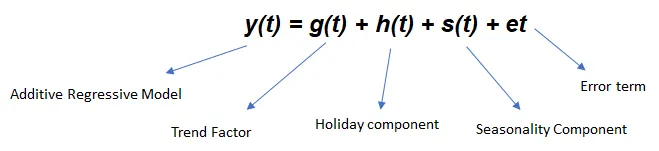

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [103]:
#df.columns

In [104]:
# #PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'timestamp': 'ds', feature: 'y'})
df_copy['y'] = pd.to_numeric(df_copy['y'])
df_copy['ds'] = pd.to_datetime(df_copy['ds'])


# Set forecast start date
forecast_start_dt = date(2023, 12, 25)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
#print("Forecast start date:", forecast_start_date)

# # Create training set
train_set = df_copy[(df_copy['ds'] < forecast_start_date)]


if train_set['y'].notna().sum() < 2:
    print("Error: Not enough non-NaN rows in the training set.")

# Initialize and train the Prophet model
m = Prophet()

m.fit(train_set)

# Create future DataFrame with 20-minute intervals for the specified number of days
future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
fcst_prophet_train = m.predict(future)

# Filter to get the forecasted data
filter = fcst_prophet_train['ds'] >= forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds', 'yhat']]

#print(predicted_df)

13:14:36 - cmdstanpy - INFO - Chain [1] start processing
13:14:36 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
predicted_df.head(10)

,ds,yhat
1728,2023-12-25 00:00:00,1.23
1729,2023-12-25 00:20:00,0.81
1730,2023-12-25 00:40:00,0.53
1731,2023-12-25 01:00:00,0.42
1732,2023-12-25 01:20:00,0.52
1733,2023-12-25 01:40:00,0.89
1734,2023-12-25 02:00:00,1.55
1735,2023-12-25 02:20:00,2.52
1736,2023-12-25 02:40:00,3.81
1737,2023-12-25 03:00:00,5.39


<b> variable considerations for prophet model: </b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [106]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [107]:
# # Remove rows with NaN values in ytrue
# predicted_df = predicted_df.dropna(subset=['ytrue'])

# # Filter out rows where ytrue is zero
# predicted_df = predicted_df[predicted_df['ytrue'] != 0]


In [108]:
predicted_df.head()

,ds,yhat,ytrue
0,2023-12-25 00:00:00,1.23,6.00
1,2023-12-25 00:20:00,0.81,1.00
2,2023-12-25 00:40:00,0.53,2.00
3,2023-12-25 01:00:00,0.42,2.00
4,2023-12-25 01:20:00,0.52,0.00


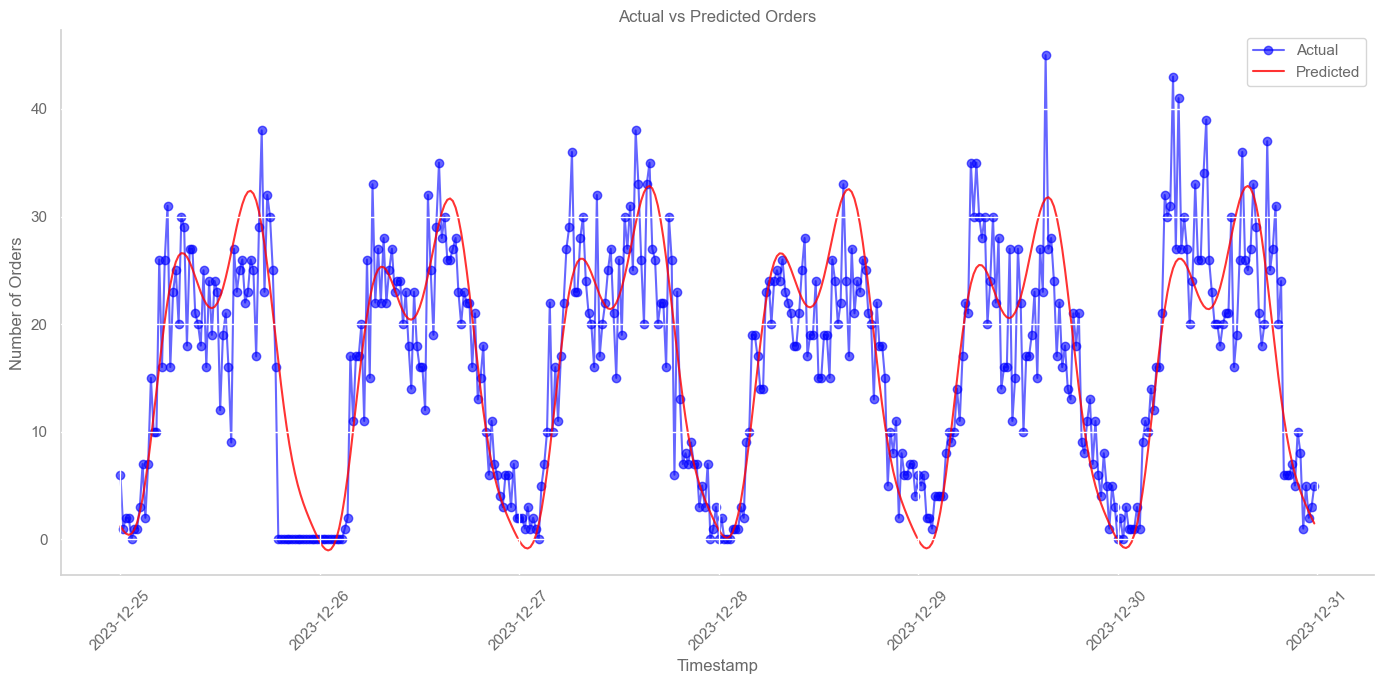

In [109]:
# Plotting the results
plt.figure(figsize=(14, 7))  # Adjust the figure size as needed

# Plot actual values
plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual', color='blue', marker='o', linestyle='-', alpha=0.6)

# Plot predicted values
plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', color='red', linestyle='-', alpha=0.8)

# Add title and labels
plt.title('Actual vs Predicted Orders')
plt.xlabel('Timestamp')
plt.ylabel('Number of Orders')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot

In [110]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

37.464983533451196

In [111]:
# Initialize and train the Prophet model
m = Prophet()
m.fit(train_set)

# Cross-validation parameters
initial = '7 days'  #capture one week of data
period = '1 day'    
horizon = '1 day'  

# Perform cross-validation
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/16 [00:00<?, ?it/s]13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:03,  4.74it/s]13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:03,  4.51it/s]13:14:38 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:03,  4.13it/s]13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:03,  3.98it/s]13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:39 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:01<00:02,  4.05it/s]13:14:39 - cmdstanpy - INFO - Chain [1] start processi

In [112]:
#total_sales_df[total_sales_df['PRODUCE']<10000]

In [113]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 02:40:00,3.69,1.92,1.51,0.99,1.32,1.00
1,0 days 03:00:00,4.06,2.02,1.59,0.84,1.18,1.00
2,0 days 03:20:00,4.80,2.19,1.69,0.62,1.02,0.99
3,0 days 03:40:00,5.97,2.44,1.87,0.50,0.86,0.98
4,0 days 04:00:00,6.65,2.58,2.02,0.45,0.70,0.98


In [114]:
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 02:40:00,3.69,1.92,1.51,0.99,1.32,1.00
1,0 days 03:00:00,4.06,2.02,1.59,0.84,1.18,1.00
2,0 days 03:20:00,4.80,2.19,1.69,0.62,1.02,0.99
3,0 days 03:40:00,5.97,2.44,1.87,0.50,0.86,0.98
4,0 days 04:00:00,6.65,2.58,2.02,0.45,0.70,0.98


In [115]:
df_p.tail()

,horizon,mse,rmse,mae,mdape,smape,coverage
60,0 days 22:40:00,11.02,3.32,2.65,0.35,0.42,0.96
61,0 days 23:00:00,9.07,3.01,2.42,0.36,0.47,0.99
62,0 days 23:20:00,8.08,2.84,2.26,0.39,0.52,0.99
63,0 days 23:40:00,8.01,2.83,2.25,0.45,0.63,0.98
64,1 days 00:00:00,7.99,2.83,2.23,0.49,0.76,0.98


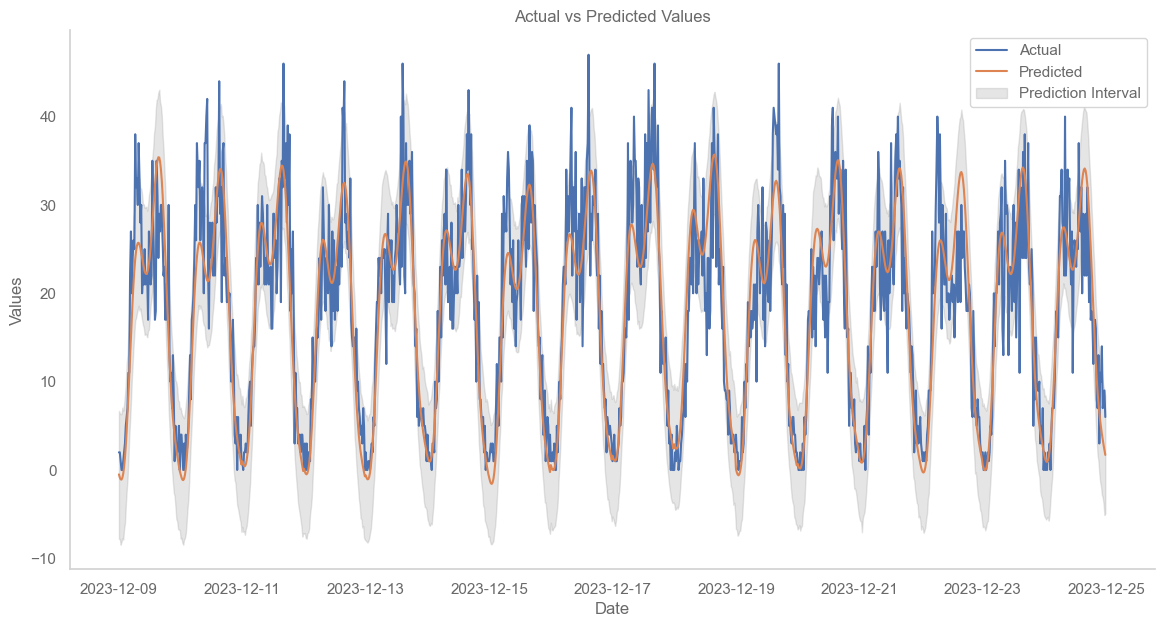

In [116]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.show()


In [117]:
df_cv['mape'] = df_cv.apply(lambda row: (abs(row['y'] - row['yhat']) / row['y'] * 100) if row['y'] != 0 else None, axis=1)
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y']

df_cv.sort_values('mape', ascending=False).head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
655,2023-12-18 02:20:00,4.70,-1.93,11.39,1.00,2023-12-17 23:40:00,370.01,True
65,2023-12-09 21:40:00,3.86,-2.95,11.06,1.00,2023-12-08 23:40:00,286.26,True
654,2023-12-18 02:00:00,3.70,-3.23,10.48,1.00,2023-12-17 23:40:00,270.09,True
2,2023-12-09 00:40:00,-1.06,-8.46,6.31,1.00,2023-12-08 23:40:00,205.88,False
291,2023-12-13 01:00:00,-1.03,-8.03,5.98,1.00,2023-12-12 23:40:00,203.18,False


In [118]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2023-12-09 00:00:00,-0.50,-7.80,6.69,2.00,2023-12-08 23:40:00,125.01,False
1,2023-12-09 00:20:00,-0.85,-7.80,6.42,2.00,2023-12-08 23:40:00,142.47,False
2,2023-12-09 00:40:00,-1.06,-8.46,6.31,1.00,2023-12-08 23:40:00,205.88,False
3,2023-12-09 01:00:00,-1.08,-8.13,6.36,0.00,2023-12-08 23:40:00,NaN,False
4,2023-12-09 01:20:00,-0.88,-7.72,7.07,0.00,2023-12-08 23:40:00,NaN,False


Optimizing for "PRODUCE" feature. What that means is... <b> lets hypertune this model! </b>

In [119]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Adjust cross-validation parameters for your data
initial = '7 days'  # Shortened initial period
period = '1 day'     # Cross-validation step period
horizon = '1 days'   # Shortened forecast horizon

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Output the tuning results
print(tuning_results)

13:14:43 - cmdstanpy - INFO - Chain [1] start processing
13:14:43 - cmdstanpy - INFO - Chain [1] done processing
13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing
13:14:58 - cmdstanpy - INFO - Chain [1] start processing
13:14:58 - cmdstanpy - INFO - Chain [1] done processing
13:15:08 - cmdstanpy - INFO - Chain [1] start processing
13:15:09 - cmdstanpy - INFO - Chain [1] done processing
13:15:20 - cmdstanpy - INFO - Chain [1] start processing
13:15:20 - cmdstanpy - INFO - Chain [1] done processing
13:15:25 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing
13:15:31 - cmdstanpy - INFO - Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing
13:15:36 - cmdstanpy - INFO - Chain [1] start processing
13:15:36 - cmdstanpy - INFO - Chain [1] done processing
13:15:41 - cmdstanpy - INFO - Chain [1] start processing
13:15:41 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  rmse
0                      0.00                     0.01  5.25
1                      0.00                     0.10  5.24
2                      0.00                     1.00  5.24
3                      0.00                    10.00  5.26
4                      0.01                     0.01  5.22
5                      0.01                     0.10  5.21
6                      0.01                     1.00  5.21
7                      0.01                    10.00  5.22
8                      0.10                     0.01  5.27
9                      0.10                     0.10  5.25
10                     0.10                     1.00  5.25
11                     0.10                    10.00  5.25
12                     0.50                     0.01  5.41
13                     0.50                     0.10  5.56
14                     0.50                     1.00  5.55
15                     0.50                    10.00  5.

In [120]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale  rmse
0                      0.00                     0.01  5.25
1                      0.00                     0.10  5.24
2                      0.00                     1.00  5.24
3                      0.00                    10.00  5.26
4                      0.01                     0.01  5.22
5                      0.01                     0.10  5.21
6                      0.01                     1.00  5.21
7                      0.01                    10.00  5.22
8                      0.10                     0.01  5.27
9                      0.10                     0.10  5.25
10                     0.10                     1.00  5.25
11                     0.10                    10.00  5.25
12                     0.50                     0.01  5.41
13                     0.50                     0.10  5.56
14                     0.50                     1.00  5.55
15                     0.50                    10.00  5.

In [121]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
5,0.01,0.10,5.21
6,0.01,1.00,5.21
4,0.01,0.01,5.22
7,0.01,10.00,5.22
1,0.00,0.10,5.24
2,0.00,1.00,5.24
9,0.10,0.10,5.25
0,0.00,0.01,5.25
10,0.10,1.00,5.25
11,0.10,10.00,5.25


In [122]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale   0.01
seasonality_prior_scale   0.10
rmse                      5.21
Name: 0, dtype: float64

In [123]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.1,
 'rmse': 5.2112774055455695}

In [124]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


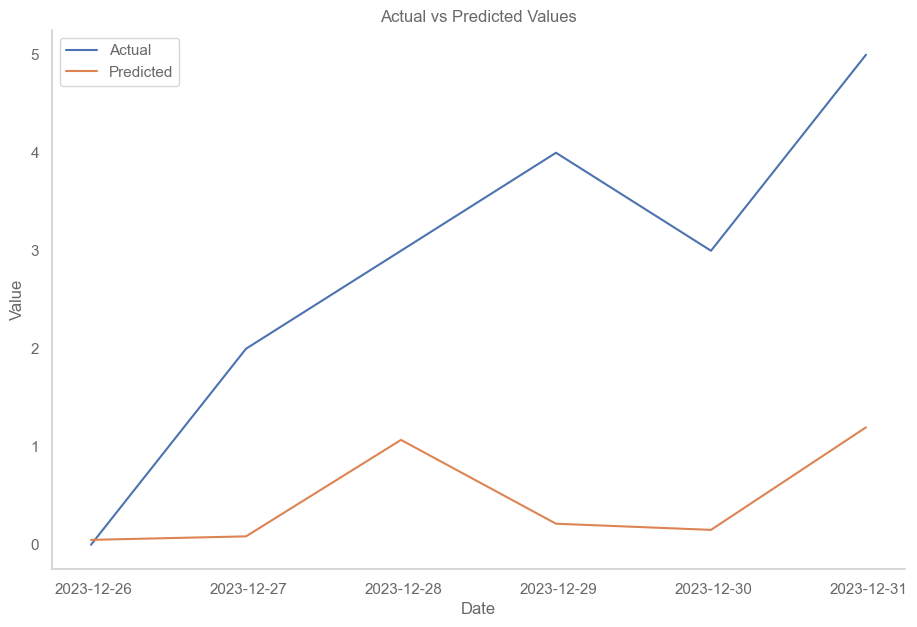

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 7))
plt.plot(predicted_df['ds'], predicted_df['ytrue'], label='Actual')
plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [125]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

13:16:26 - cmdstanpy - INFO - Chain [1] start processing
13:16:27 - cmdstanpy - INFO - Chain [1] done processing


85.13383889062618